##**----------------------------------------------------------------------------------------------------------------**
## **------------------------------------Partie I : Préparation des données------------------------------------**
##**----------------------------------------------------------------------------------------------------------------**

## **Instruction 1 : importer les librairies d'analyse et visualisation des données**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## **Instruction 2 : connecter votre notebook à la plateforme WanDB (A corriger)**

In [2]:
import wandb
wandb.login(key="9414e8ff95ebd7016321b49a7cd54fac7c75fd9d")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\maxim\_netrc
wandb: Currently logged in as: maximilien003 (maximilien003-universit-de-mons) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## **Instruction 4 : importer les librairies nécessaires pour la partie Deep Learning**

In [3]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126

In [4]:
!pip install pytorch_lightning==2.5.0 torchmetrics==1.6.1 torchinfo

In [5]:
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningModule, Trainer, seed_everything
from sklearn.metrics import r2_score
from pytorch_lightning.loggers import WandbLogger
seed_everything(42, workers=True)
torch.use_deterministic_algorithms(True)
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

Seed set to 42


## **Question 1 : télécharger la base de données accessible via le lien**

In [6]:
housing = pd.read_csv("kc_house_data.csv")

## **Question 2 : afficher les dimensions de la base de données ainsi que quelques ligne**

In [7]:
display(housing.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
print(housing.shape)

(21613, 21)


## **Instruction 5 : exécuter la fonction de préparation et prétraitement de données**

In [9]:
def preprocess_data(housing):
    housing_copy = housing.copy()
    housing_copy['sales_yr']=pd.to_datetime(housing_copy['date']).dt.year
    # add the age of the buildings when the houses were sold as a new column
    housing_copy['age']=housing_copy['sales_yr']-housing_copy['yr_built']
    selected_features = [ 'bedrooms', 'bathrooms', 'sqft_living',
           'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
           'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
           'lat', 'long', 'sqft_living15', 'sqft_lot15','age']
    target = 'price'
    return housing_copy[selected_features],  housing_copy[target]

## **Question 3 : appliquer cette fonction pour préparer et prétraiter vos données**

In [10]:
X,Y = preprocess_data(housing)

## **Instruction 6 : diviser les données en train (80%), validation (10%) et test (10%)**

In [11]:
X_train , X_tmp, Y_train, Y_tmp = train_test_split(X,Y,test_size=0.2,random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_tmp,Y_tmp,test_size=0.5,random_state=42)

# **Instruction 7 : normaliser les données en utilisant la fonction « normalize_data »**

In [12]:
def normalize_data(X_train, X_val, X_test, y_train, y_val, y_test):
    # Initialisation des scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Mise à l'échelle des données d'entrée (X)
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # Mise à l'échelle de la cible (y)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_X, scaler_y

In [13]:
X_train_transformed, X_val_transformed, X_test_transformed, Y_train_transformed, Y_val_transformed, Y_test_transformed, scaler, y_scaler = normalize_data(X_train, X_val, X_test, Y_train, Y_val, Y_test)

## **Instruction 8 :exécuter le code de la classe « TabularDataset » pour générer des couples (X, Y)**

In [14]:
class TabularDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        # essential for dataloaders to estimate the dataset length
        return len(self.data)
    def __getitem__(self, idx):
        # convert x and y to tensors
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

## **Instruction 9 : créer vos Data loaders pour charger les données sous forme de batchs**

In [15]:
# Create DataLoaders
train_dataset = TabularDataset(X_train_transformed, Y_train_transformed)
val_dataset = TabularDataset(X_val_transformed, Y_val_transformed)
test_dataset = TabularDataset(X_test_transformed, Y_test_transformed)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## **Instruction 10 : calcul des métriques d’évaluation de modèles MAE et R2**

In [16]:
def custom_MAE(y_true, y_pred,scaler):
    y_true = y_true.detach().cpu().numpy().reshape(-1, 1)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1, 1)
    y_true_unscaled = scaler.inverse_transform(y_true)
    y_pred_unscaled = scaler.inverse_transform(y_pred)
    return np.mean(np.abs(y_true_unscaled - y_pred_unscaled))

def custom_r2_score(y_true, y_pred,scaler):
      y_true = y_true.detach().cpu().numpy().reshape(-1, 1)
      y_pred = y_pred.detach().cpu().numpy().reshape(-1, 1)
      y_true_unscaled = scaler.inverse_transform(y_true)
      y_pred_unscaled = scaler.inverse_transform(y_pred)
      r2 = r2_score(y_true_unscaled, y_pred_unscaled)
      return r2

##**----------------------------------------------------------------------------------------------------------------**
## **------------------Partie II : Développement du 1er réseau de neurones à 01 couche------------------**
##**----------------------------------------------------------------------------------------------------------------**

## **Instrcution 11 : exécuter et analyser attentivement la classe «BaseModel»**

In [17]:
class BaseModel(LightningModule):
    def __init__(self, model, loss_fn, scaler_y, lr=6e-3):
        super(BaseModel, self).__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr
        self.scaler_y = scaler_y

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        mae = custom_MAE(y, y_pred, self.scaler_y)
        r2 = custom_r2_score(y, y_pred, self.scaler_y)
        self.log_dict({"train_loss": loss, "train_mae": mae, "train_r2": r2}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        mae = custom_MAE(y, y_pred, self.scaler_y)
        r2 = custom_r2_score(y, y_pred, self.scaler_y)
        self.log_dict({"val_loss": loss, "val_mae": mae, "val_r2": r2}, on_step=False, on_epoch=True, prog_bar=True,logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y)
        mae = custom_MAE(y, y_pred, self.scaler_y)
        r2 = custom_r2_score(y, y_pred, self.scaler_y)
        self.log_dict({"test_loss": loss, "test_mae": mae, "test_r2": r2}, on_step=False, on_epoch=True, prog_bar=True,logger=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## **Instruction 12 : définir l’architecture neuronale de votre 1er modèle à 01 seule couche**

In [18]:
class MLPModelSingleLayer(nn.Module):
    def __init__(self, input_dim):
        super(MLPModelSingleLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
    def forward(self, x):
        x = self.fc1(x)
        return x

## **Instruction 13 :visualiser l'architecture de votre modèle à l'aide de la fonction «summary()»**

In [19]:
modelSingleLayer = MLPModelSingleLayer(input_dim=X_train.shape[1])
summary(modelSingleLayer,(1,X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
MLPModelSingleLayer                      [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    20
Total params: 20
Trainable params: 20
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## **Question 4 : lancer l’entraînement avec les paramètres de l'énoncé**

In [ ]:
seed_everything(42, workers=True)

loss_fn = nn.MSELoss()
wandb_logger = WandbLogger(project="tp house price", name="Neural_1", log_model=True)

model1 = BaseModel(modelSingleLayer, loss_fn, y_scaler, lr=0.0120)

trainer = Trainer(max_epochs=20, deterministic=True, logger=wandb_logger)

trainer.fit(model1, train_loader, val_loader)

## **Question 5 :vérifier et interpréter les résultats d'entraînement de votre 1er modèle via Wandb**

In [21]:
# https://wandb.ai/maximilien003-universit-de-mons/tp%20house%20price?nw=nwusermaximilien003

## **Question 6 : évaluer le modèle avec les données de test en utiliser la fonction «trainer.test»**

In [22]:
trainer.test(model1, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0010202736593782902
        test_mae                147662.0625
         test_r2            0.6692745685577393
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_loss,▁
test_mae,▁
test_r2,▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁███████████████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_loss,▄▃▄▁▁▁▁▂▃▁▂▆▂▁▂█▅▁▁▂
val_mae,▅▄▅▂▂▂▁▃▃▁▂▆▂▂▂█▆▂▁▄
val_r2,▅▆▅▇███▇▆█▇▃▇█▇▁▃██▆


## **Question 7 : calculer les prédictions des données de test avec la fonction «trainer.predict»**

In [23]:
predictions1 = trainer.predict(model1, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

## **Question 8 : analyser et exécuter la fonction «plot_model_predictions»**

In [24]:
def plot_model_predictions(predictions, y_test):
    # Faire les prédictions
    test_predictions = torch.cat(predictions, dim=0).detach().cpu().numpy()

    # Créer un DataFrame pour la visualisation
    result = pd.DataFrame({
        'house': list(range(100)),
        'Real Values': y_test.values[:100].reshape(-1),
        'Predictions': y_scaler.inverse_transform(test_predictions)[:100].reshape(-1)
    })

    # Créer le graphique avec seaborn
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=result, x='house', y='Real Values', marker='o', label='Real Values')
    sns.lineplot(data=result, x='house', y='Predictions', marker='o', label='Predictions')

    plt.title('Prédictions vs Valeurs Réelles')
    plt.xlabel('Index de Maison')
    plt.ylabel('Valeur de Maison')
    plt.legend(title='Valeurs')
    plt.show()

## **Question 9 : appliquer la fonction « plot_model_predictions » aux données de test.**

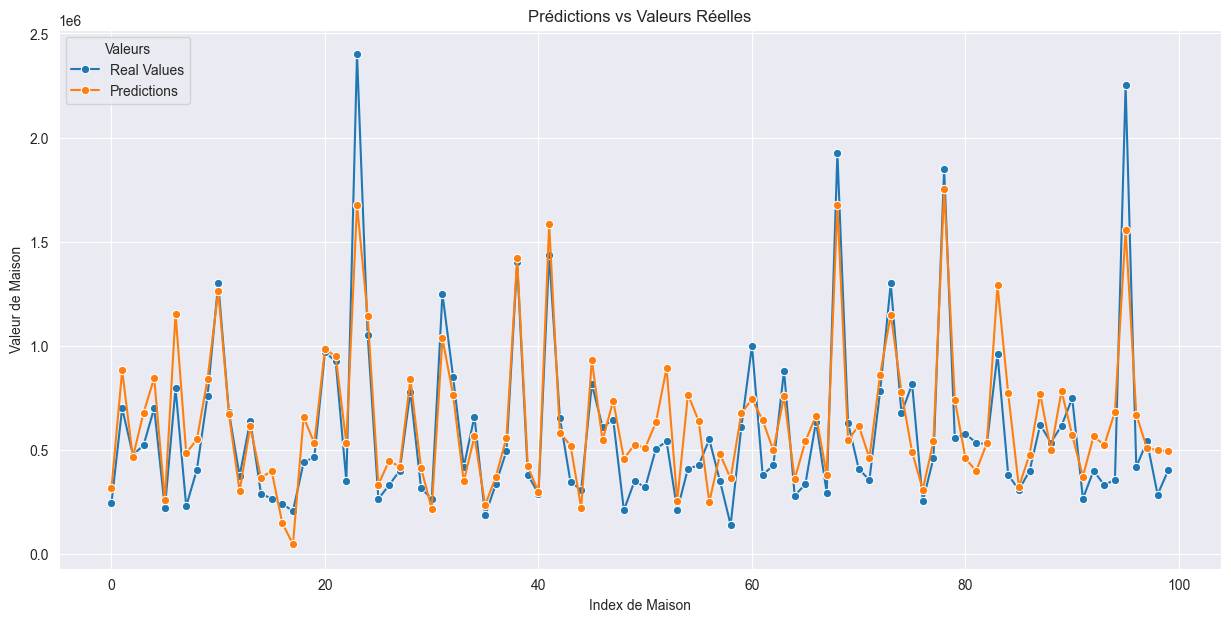

In [25]:
plot_model_predictions(predictions1, Y_test)

## **Question 9bis : donner votre interpération du résultat de prédictions du 1er modèle**

In [26]:
# A part les extremas c'est bien proche

##**----------------------------------------------------------------------------------------------------------------**
## **---------------Partie III : Développement du 2ème réseau de neurones à 02 couches----------------**
##**----------------------------------------------------------------------------------------------------------------**

## **Question 10 : créer le 2ème modèle basé sur la structure décite dans l'énoncé**

In [27]:
class MLPModel2(nn.Module):
    def __init__(self, input_size=19):
        super(MLPModel2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),  # Couche 1 : 19 entrées, 64 sorties
            nn.ReLU(),                 # Fonction d’activation ReLU
            nn.Linear(64, 1)           # Couche 2 : 64 entrées, 1 sortie
        )

    def forward(self, x):
        return self.layers(x)

In [28]:
model2 = MLPModel2(input_size=19)

## **Question 11: Entraîner 2ème modèle avec les param d'énoncé + Evaluer, prédire et interpréter**

In [ ]:
loss_fn = nn.MSELoss()
wandb_logger = WandbLogger( project="tp house price", name="Neural_2", log_model=True,)

model2 = BaseModel(model2, loss_fn, y_scaler, lr=0.0022)

trainer = Trainer( max_epochs=100, deterministic=True, logger=wandb_logger)

trainer.fit(model2, train_loader, val_loader)

In [30]:
trainer.test(model2, test_loader)
predictions2 = trainer.predict(model2, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0003721276589203626
        test_mae               82219.0859375
         test_r2            0.8612803816795349
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

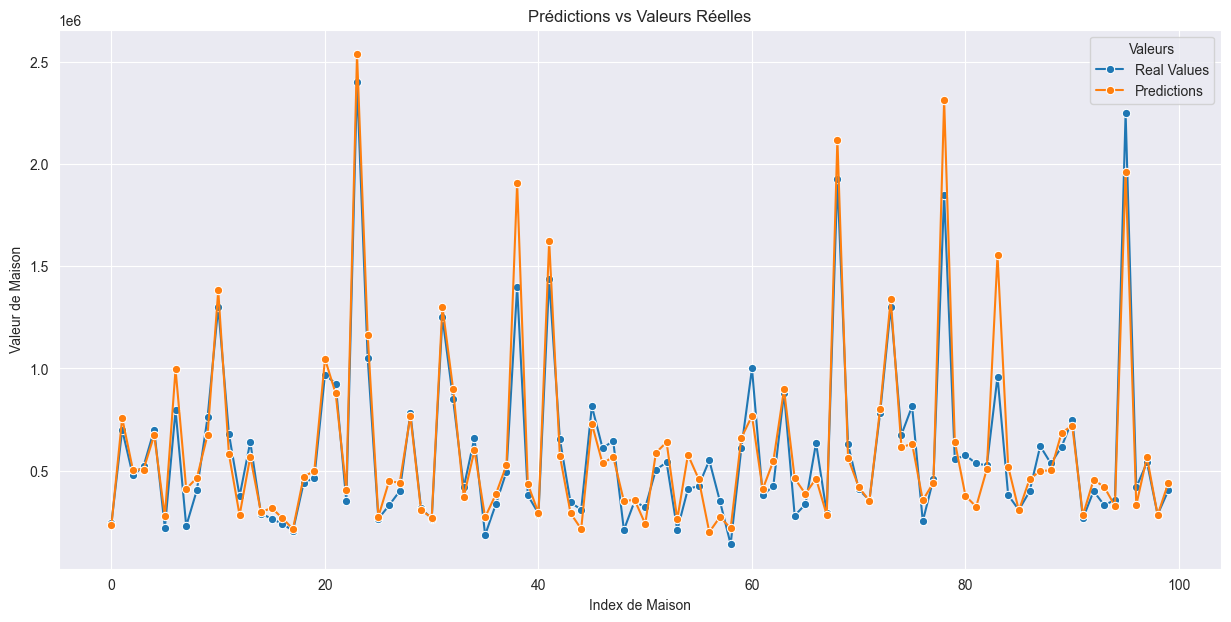

In [31]:
plot_model_predictions(predictions2, Y_test)

In [32]:
# C'est mieux les extremas sont plus proches des valeurs réelles

##**----------------------------------------------------------------------------------------------------------------**
## **---------------Partie IV : Développement du 3ème réseau de neurones à 04 couches----------------**
##**----------------------------------------------------------------------------------------------------------------**

## **Question 12 : créer le 3ème modèle basé sur la structure décite dans l'énoncé**


In [33]:
class MLPModel3(nn.Module):
    def __init__(self, input_size=19):  # 19 features comme dans votre erreur précédente
        super(MLPModel3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),  # Couche 1 : 19 entrées, 128 sorties
            nn.ReLU(),                  # Fonction d’activation ReLU
            nn.Linear(128, 64),         # Couche 2 : 128 entrées, 64 sorties
            nn.ReLU(),                  # Fonction d’activation ReLU
            nn.Linear(64, 32),          # Couche 3 : 64 entrées, 32 sorties
            nn.ReLU(),                  # Fonction d’activation ReLU
            nn.Linear(32, 1)            # Couche 4 : 32 entrées, 1 sortie
        )

    def forward(self, x):
        return self.layers(x)

In [34]:
model3 = MLPModel3()

## **Question 13: Entraîner 3ème modèle avec les param d'énoncé + Evaluer, prédire et interpréter**

In [35]:
loss_fn = nn.MSELoss()
wandb_logger = WandbLogger(project="tp house price", name="Neural_3", log_model=True)

model3 = BaseModel(model3, loss_fn, y_scaler, lr=0.00063)

trainer = Trainer(max_epochs=100, deterministic=True, logger=wandb_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model3, train_loader, val_loader)
trainer.test(model3, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

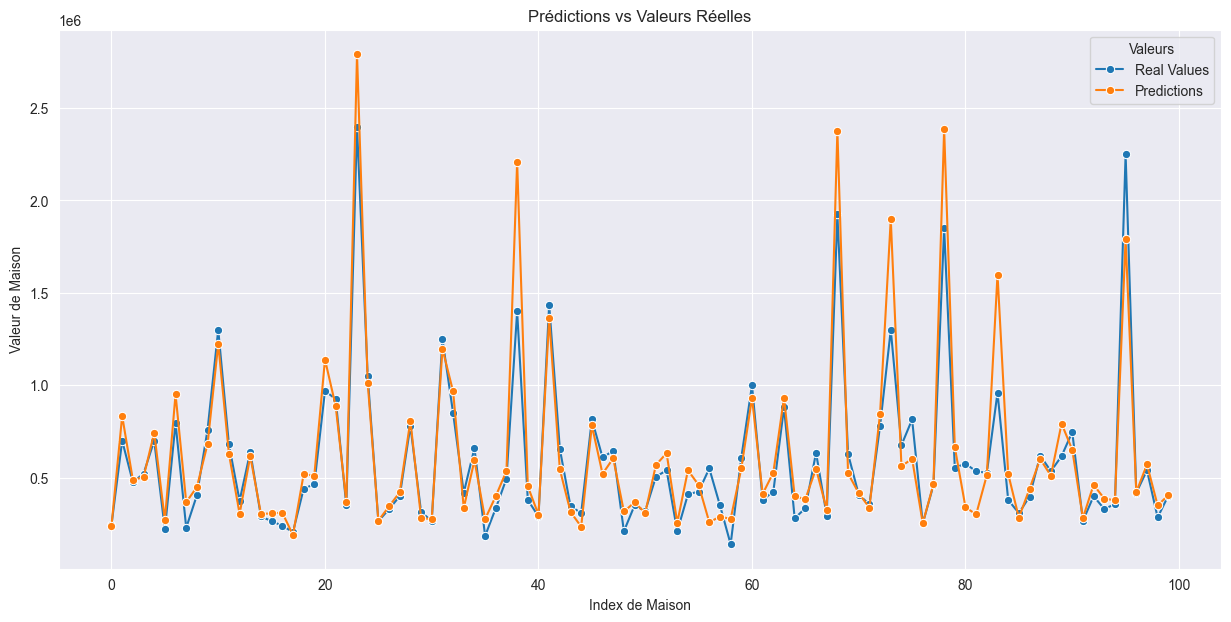

In [37]:
predictions3 = trainer.predict(model3, test_loader)
plot_model_predictions(predictions3, Y_test)

In [38]:
# La galère maintenant ça dépasse

##**----------------------------------------------------------------------------------------------------------------**
## **---------Partie V : Développement du 4ème réseau de neurones à 05 couches + Dropout ----------**
##**----------------------------------------------------------------------------------------------------------------**

## **Question 14 : créer le 4ème modèle basé sur la structure décite dans l'énoncé**


In [39]:
class MLPModel4(nn.Module):
    def __init__(self, input_size=19, dropout_rate=0.2):  # 19 features, Dropout de 20%
        super(MLPModel4, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),  # Couche 1 : 19 entrées, 256 sorties
            nn.ReLU(),                   # Activation ReLU
            nn.Dropout(p=dropout_rate),  # Dropout de 20% après ReLU
            nn.Linear(256, 128),         # Couche 2 : 256 entrées, 128 sorties
            nn.ReLU(),                   # Activation ReLU
            nn.Dropout(p=dropout_rate),  # Dropout de 20% après ReLU
            nn.Linear(128, 64),          # Couche 3 : 128 entrées, 64 sorties
            nn.ReLU(),                   # Activation ReLU
            nn.Linear(64, 32),           # Couche 4 : 64 entrées, 32 sorties
            nn.ReLU(),                   # Activation ReLU
            nn.Linear(32, 1)             # Couche 5 : 32 entrées, 1 sortie
        )

    def forward(self, x):
        return self.layers(x)

In [40]:
model4 = MLPModel4()

## **Question 15: Entraîner 4ème modèle avec les param d'énoncé + Evaluer, prédire et interpréter**

In [41]:
loss_fn = nn.MSELoss()
wandb_logger = WandbLogger(project="tp house price", name="Neural_4", log_model=True)

model4 = BaseModel(model4, loss_fn, y_scaler, lr=0.00131)

trainer = Trainer(max_epochs=100, deterministic=True, logger=wandb_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model4, train_loader, val_loader)
trainer.test(model4, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

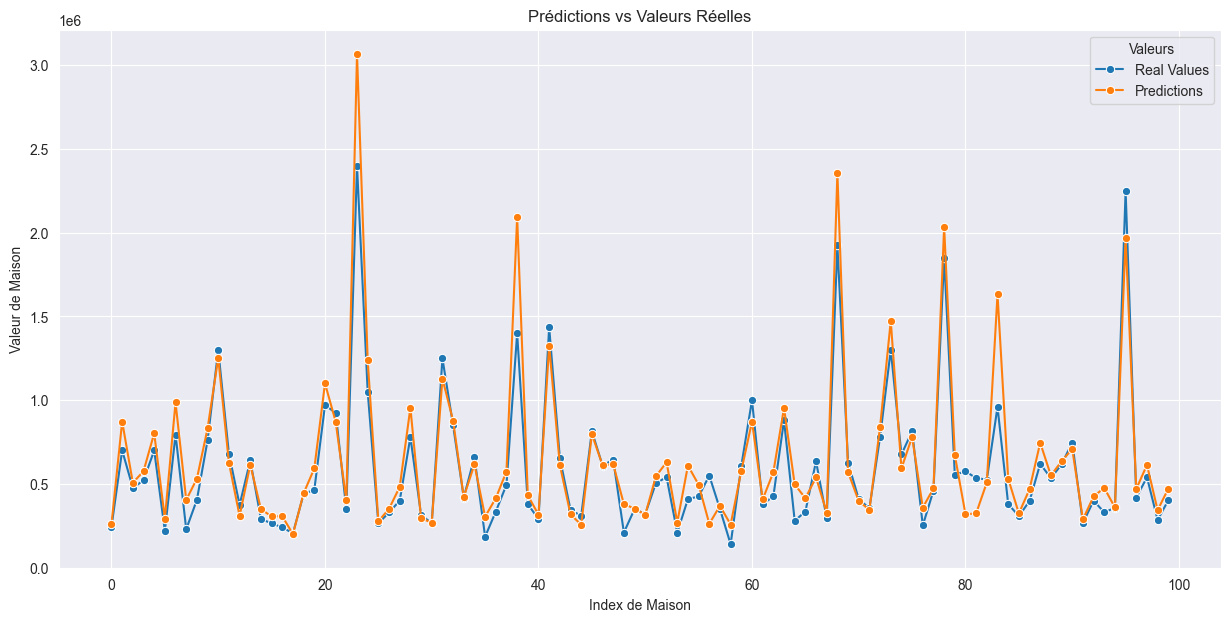

In [43]:
predictions4 = trainer.predict(model4, test_loader)
plot_model_predictions(predictions4, Y_test)

In [44]:
# Toujours pas fou